In [1]:
%matplotlib inline
import os
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

In [2]:
data = pd.read_csv(
    os.path.join('train.csv.bz2')
)

usholidays = pd.read_csv(
    os.path.join('external_data.csv')
)
data_weather = pd.read_csv(
    os.path.join('external_data_copie.csv')
)
test = pd.read_csv(
    os.path.join('classeur.csv'), sep = ';'
)

In [66]:
data_weather.columns

Index(['Date', 'AirPort', 'Max TemperatureC', 'Mean TemperatureC',
       'Min TemperatureC', 'Dew PointC', 'MeanDew PointC', 'Min DewpointC',
       'Max Humidity', 'Mean Humidity', 'Min Humidity',
       'Max Sea Level PressurehPa', 'Mean Sea Level PressurehPa',
       'Min Sea Level PressurehPa', 'Max VisibilityKm', 'Mean VisibilityKm',
       'Min VisibilitykM', 'Max Wind SpeedKm/h', 'Mean Wind SpeedKm/h',
       'Max Gust SpeedKm/h', 'Precipitationmm', 'CloudCover', 'Events',
       'WindDirDegrees'],
      dtype='object')

In [3]:
def _encode_dates(X):
    # Make sure that DateOfDeparture is of dtype datetime
    X = X.copy()  # modify a copy of X
    X.loc[:, "DateOfDeparture"] = pd.to_datetime(X['DateOfDeparture'])
    # Encode the date information from the DateOfDeparture columns
    X.loc[:, 'year'] = X['DateOfDeparture'].dt.year
    X.loc[:, 'month'] = X['DateOfDeparture'].dt.month
    X.loc[:, 'day'] = X['DateOfDeparture'].dt.day
    X.loc[:, 'weekday'] = X['DateOfDeparture'].dt.weekday
    X.loc[:, 'week'] = X['DateOfDeparture'].dt.week
    X.loc[:, 'n_days'] = X['DateOfDeparture'].apply(
        lambda date: (date - pd.to_datetime("1970-01-01")).days
    )
    
    #ADD Holidays
    we = [4, 5, 6]
    ho_we = [51, 35, 21, 26, 46]
    ho = [1, 52, 27, 47]
    ho_0 = [36, 22]
    summer = range(22, 35)
    X.loc[:, 'holiday'] = np.where((X['week'].isin(ho)) |
                                    ((X['week'].isin(ho_we)) & (X['weekday'].isin(we))) |
                                    ((X['week'].isin(ho_0)) & (X['weekday'] == 0)) |
                                   ((X['week'].isin(summer)) & (X['weekday'] == 5))
                                   , 1, 0)
    # Finally we can drop the original columns from the dataframe
    return X.drop(columns=["DateOfDeparture"])  
X_merged2 = _encode_dates(data.copy())

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  # Remove the CWD from sys.path while we load stuff.


In [4]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(X_merged2['Arrival'].unique())

X_merged2['Arrival'] = le.transform(X_merged2['Arrival'])
X_merged2['Departure'] = le.transform(X_merged2['Departure'])
X_merged2

,Departure,Arrival,WeeksToDeparture,log_PAX,std_wtd,year,month,day,weekday,week,n_days,holiday
0,15,4,12.875000,12.331296,9.812647,2012,6,19,1,25,15510,0
1,9,3,14.285714,10.775182,9.466734,2012,9,10,0,37,15593,0
2,3,10,10.863636,11.083177,9.035883,2012,10,5,4,40,15618,0
3,0,15,11.480000,11.169268,7.990202,2011,10,9,6,40,15256,0
4,3,19,11.450000,11.269364,9.517159,2012,2,21,1,8,15391,0
...,...,...,...,...,...,...,...,...,...,...,...,...
8897,5,0,9.263158,10.427055,7.316967,2011,10,2,6,39,15249,0
8898,4,15,12.772727,12.201552,10.641034,2012,9,25,1,39,15608,0
8899,19,9,11.047619,10.508746,7.908705,2012,1,19,3,3,15358,0
8900,15,16,6.076923,10.174042,4.030334,2013,2,3,6,5,15739,0


In [76]:
min(L)

0.598127456917618

In [75]:
L=[]
for i in range(8,21):
    X_transform = X_merged2.copy()
    categorical_data = ['WeeksToDeparture', 'std_wtd']

    enc = KBinsDiscretizer(n_bins=i, encode='ordinal', strategy='kmeans') 
    enc.fit(X_transform[categorical_data])
    X_transform[categorical_data] = enc.transform(X_transform[categorical_data])
    X = X_transform.copy()
    y = X['log_PAX']
    X.drop(['log_PAX'], axis=1, inplace=True)
    ###
    from xgboost import XGBRegressor
    model = XGBRegressor()
    ###
    scores = cross_val_score(
        model, X, y, cv=5, scoring='neg_mean_squared_error'
    )

    rmse_scores = np.sqrt(-scores)
    L.append(i)
    L.append(np.mean(rmse_scores))

[15:10:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:10:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:10:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:10:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:10:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:10:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:10:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:10:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:10:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

In [5]:
from sklearn.preprocessing import KBinsDiscretizer
X_transform = X_merged2.copy()
categorical_data = ['WeeksToDeparture', 'std_wtd']

enc = KBinsDiscretizer(n_bins=9, encode='ordinal', strategy='kmeans') 
enc.fit(X_transform[categorical_data])
X_transform[categorical_data] = enc.transform(X_transform[categorical_data])

X_transform

,Departure,Arrival,WeeksToDeparture,log_PAX,std_wtd,year,month,day,weekday,week,n_days,holiday
0,15,4,5.0,12.331296,5.0,2012,6,19,1,25,15510,0
1,9,3,6.0,10.775182,5.0,2012,9,10,0,37,15593,0
2,3,10,3.0,11.083177,4.0,2012,10,5,4,40,15618,0
3,0,15,4.0,11.169268,3.0,2011,10,9,6,40,15256,0
4,3,19,4.0,11.269364,5.0,2012,2,21,1,8,15391,0
...,...,...,...,...,...,...,...,...,...,...,...,...
8897,5,0,2.0,10.427055,2.0,2011,10,2,6,39,15249,0
8898,4,15,5.0,12.201552,6.0,2012,9,25,1,39,15608,0
8899,19,9,3.0,10.508746,3.0,2012,1,19,3,3,15358,0
8900,15,16,0.0,10.174042,0.0,2013,2,3,6,5,15739,0


In [89]:
from sklearn.model_selection import GridSearchCV

X = X_transform.copy()
y = X['log_PAX']
X.drop(['log_PAX', 'year', 'std_wtd'], axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y)

parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:squarederror'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5,10,15],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [1000, 1250, 1500, 1750, 2000],
              'min_child_weight': [1, 3, 5]}

xgb1 = XGBRegressor()

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 5,
                        n_jobs = 5,
                        verbose=True,
                        scoring ='neg_mean_squared_error')

xgb_grid.fit(X, y)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 5 folds for each of 135 candidates, totalling 675 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  3.9min
//anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed: 32.3min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed: 77.2min
[Parallel(n_jobs=5)]: Done 675 out of 675 | elapsed: 118.5min finished


-0.13221370992646236
{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 10, 'min_child_weight': 5, 'n_estimators': 1000, 'nthread': 4, 'objective': 'reg:squarederror', 'silent': 1, 'subsample': 0.7}


In [8]:
#XGB

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

X = X_transform.copy()
y = X['log_PAX']
X.drop(['log_PAX'], axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y)

###
#early_stopping_rounds
from xgboost import XGBRegressor
model = XGBRegressor()
###

scores = cross_val_score(
    model, X, y, cv=5, scoring='neg_mean_squared_error'
)

rmse_scores = np.sqrt(-scores)

print(
    f"RMSE: {np.mean(rmse_scores):.4f} +/- {np.std(rmse_scores):.4f}"
)

[10:48:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:48:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:48:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:48:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:48:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 0.5988 +/- 0.0155


[10:48:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


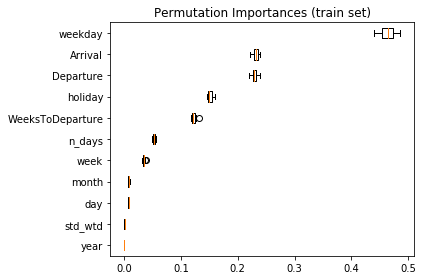

In [9]:
from sklearn.inspection import permutation_importance
model.fit(X,y)

feature_importances = permutation_importance(
    model, X, y, n_repeats=15
)

sorted_idx = feature_importances.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(feature_importances.importances[sorted_idx].T,
           vert=False, labels=X.columns[sorted_idx])
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

In [8]:
#Linear regression

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

X = X_merged2.copy()
y = X['log_PAX']
X.drop(['log_PAX'], axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y)

###
from sklearn.linear_model import LinearRegression
model = LinearRegression()
###

scores = cross_val_score(
    model, X, y, cv=5, scoring='neg_mean_squared_error'
)

rmse_scores = np.sqrt(-scores)

print(
    f"RMSE: {np.mean(rmse_scores):.4f} +/- {np.std(rmse_scores):.4f}"
)

RMSE: 0.9271 +/- 0.0204


In [26]:
#KMeans

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

X = X_merged2.copy()
y = X['log_PAX']
X.drop(['log_PAX'], axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y)

###
from sklearn.cluster import KMeans
model = KMeans(n_clusters=50)
###

scores = cross_val_score(
    model, X, y, cv=5, scoring='neg_mean_squared_error'
)

rmse_scores = np.sqrt(-scores)

print(
    f"RMSE: {np.mean(rmse_scores):.4f} +/- {np.std(rmse_scores):.4f}"
)

RMSE: 19.3237 +/- 0.3726


In [32]:
#Neurenal Network 

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

X = X_merged2.copy()
y = X['log_PAX']
X.drop(['log_PAX'], axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y)

###
from sklearn.neural_network import MLPRegressor
model = MLPRegressor(hidden_layer_sizes=(1000, ), max_iter= 500)
###

scores = cross_val_score(
    model, X, y, cv=5, scoring='neg_mean_squared_error'
)

rmse_scores = np.sqrt(-scores)

print(
    f"RMSE: {np.mean(rmse_scores):.4f} +/- {np.std(rmse_scores):.4f}"
)
print(scores)

RMSE: 1.2350 +/- 0.2175
[-0.85475946 -1.3219828  -1.66880441 -1.47407741 -2.54271453]


In [9]:
#Tree model

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

X = X_merged2.copy()
y = X['log_PAX']
X.drop(['log_PAX'], axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y)

###
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor()
###

scores = cross_val_score(
    model, X, y, cv=5, scoring='neg_mean_squared_error'
)

rmse_scores = np.sqrt(-scores)

print(
    f"RMSE: {np.mean(rmse_scores):.4f} +/- {np.std(rmse_scores):.4f}"
)

RMSE: 0.7121 +/- 0.0162


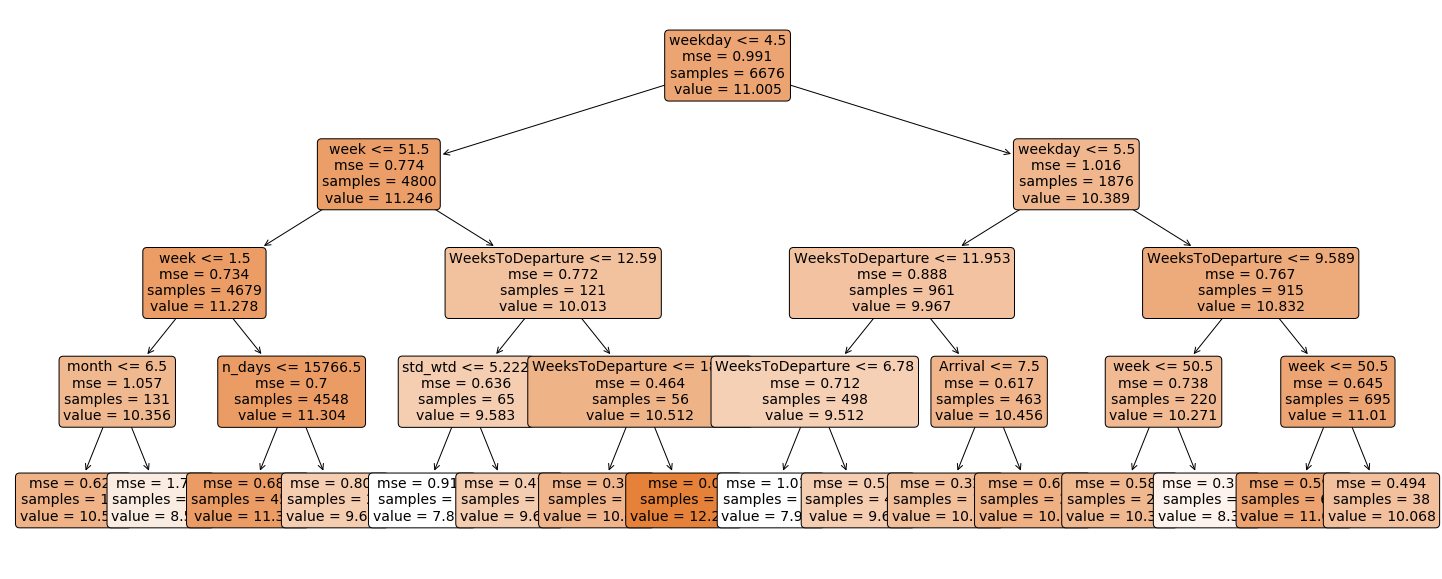

In [24]:
from sklearn.tree import plot_tree

model = DecisionTreeRegressor(max_depth = 4)
model.fit(X_train, y_train)

plt.figure(figsize=(25,10))
a = plot_tree(model, 
              feature_names=X_train.columns, 
              class_names='log_PAX', 
              filled=True, 
              rounded=True, 
              fontsize=14);

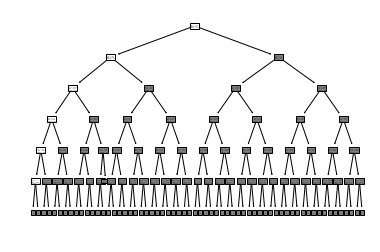

In [18]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
model = DecisionTreeRegressor()
model.fit(X_train, y_train)
plot_tree(model, max_depth = 5);

In [31]:
#XGB

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

X = X_merged2.copy()
y = X['log_PAX']
X.drop(['log_PAX'], axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y)

###
from xgboost import XGBRegressor
model = XGBRegressor()
###

scores = cross_val_score(
    model, X, y, cv=5, scoring='neg_mean_squared_error'
)

rmse_scores = np.sqrt(-scores)

print(
    f"RMSE: {np.mean(rmse_scores):.4f} +/- {np.std(rmse_scores):.4f}"
)

[12:32:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:32:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:32:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:32:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:32:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 0.6240 +/- 0.0174


[14:58:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


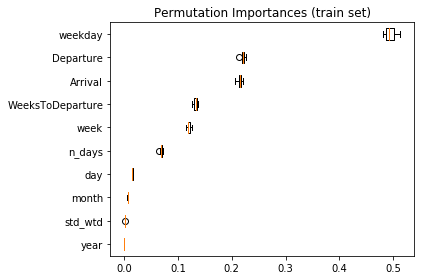

In [33]:
#Permutation 

from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

X = X_merged2.copy()
y = X['log_PAX']
X.drop(['log_PAX'], axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y)

from xgboost import XGBRegressor
regressor = XGBRegressor()

regressor.fit(X, y)

feature_importances = permutation_importance(
    regressor, X, y, n_repeats=15
)

sorted_idx = feature_importances.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(feature_importances.importances[sorted_idx].T,
           vert=False, labels=X_train.columns[sorted_idx])
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

In [59]:
X_merged3 = X_merged2.copy()
X_merged3 = pd.merge(
        X_merged3, test, how='left', on=['week','weekday'], sort=False
    )
X_merged3['Holidays'].fillna(0, inplace=True)
X_merged3['Name'].fillna("No", inplace=True)

X_merged3.drop('Name', axis=1, inplace=True)

In [66]:
from sklearn.preprocessing import KBinsDiscretizer
X_transform = X_merged3.copy()
categorical_data = ['WeeksToDeparture', 'std_wtd']

enc = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile') 
enc.fit(X_transform[categorical_data])
X_transform[categorical_data] = enc.transform(X_transform[categorical_data])

X_transform

,Departure,Arrival,WeeksToDeparture,log_PAX,std_wtd,year,month,day,weekday,week,n_days,Holidays
0,15,4,7.0,12.331296,7.0,2012,6,19,1,25,15510,0.0
1,9,3,8.0,10.775182,6.0,2012,9,10,0,37,15593,0.0
2,3,10,4.0,11.083177,5.0,2012,10,5,4,40,15618,0.0
3,0,15,5.0,11.169268,3.0,2011,10,9,6,40,15256,0.0
4,3,19,5.0,11.269364,6.0,2012,2,21,1,8,15391,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
8957,5,0,2.0,10.427055,2.0,2011,10,2,6,39,15249,0.0
8958,4,15,6.0,12.201552,8.0,2012,9,25,1,39,15608,0.0
8959,19,9,4.0,10.508746,3.0,2012,1,19,3,3,15358,0.0
8960,15,16,0.0,10.174042,0.0,2013,2,3,6,5,15739,0.0
